In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch

In [2]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator
from diffusers import (
    PNDMScheduler,
    DDIMScheduler,
    DDPMScheduler,
    DPMSolverMultistepScheduler,
    KDPM2DiscreteScheduler,
    DEISMultistepScheduler,
)

# import os
# LIB_PATH = "~/Desktop/THESIS/transtimegrad"
# os.chdir(os.path.expanduser(LIB_PATH))
from ttg.model.rnn_timegrad import TimeGradEstimator

/opt/homebrew/anaconda3/envs/ysda_env/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/opt/homebrew/anaconda3/envs/ysda_env/lib/python3.11/site-packages/gluonts/dataset/artificial/_base.py:84: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self.freq: BaseOffset = to_offset(freq)
/opt/homebrew/anaconda3/envs/ysda_env/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/opt/homebrew/anaconda3/envs/ysda_env/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
 

## Prepeare data set

In [3]:
dataset = get_dataset("solar_nips", regenerate=False)

In [4]:
dataset.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='137')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [5]:
train_grouper = MultivariateGrouper(
    max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality)
)

test_grouper = MultivariateGrouper(
    num_test_dates=int(len(dataset.test) / len(dataset.train)),
    max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
)

In [6]:
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

/opt/homebrew/anaconda3/envs/ysda_env/lib/python3.11/site-packages/gluonts/dataset/common.py:262: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.Period(val, freq)


In [7]:
def plot(
    target,
    forecast,
    prediction_length,
    prediction_intervals=(50.0, 90.0),
    color="g",
    fname=None,
):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape

    ps = [50.0] + [
        50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
    ]

    percentiles_sorted = sorted(set(ps))

    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3

    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)

        ps_data = [forecast.quantile(p / 100.0)[:, dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2

        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)

        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]
    axx[0].legend(legend, loc="upper left")

    if fname is not None:
        plt.savefig(fname, bbox_inches="tight", pad_inches=0.05)

## Evaluator

In [8]:
evaluator = MultivariateEvaluator(
    quantiles=(np.arange(20) / 20.0)[1:], target_agg_funcs={"sum": np.sum}
)

## `TimeGrad`

In [9]:
scheduler = PNDMScheduler(
    num_train_timesteps=100,
    beta_end=0.2,
    beta_schedule="squaredcos_cap_v2",
)

In [10]:
scheduler = DDPMScheduler(
    num_train_timesteps=100,
    beta_end=0.1,
    beta_schedule="squaredcos_cap_v2",
    thresholding=True,
    clip_sample=False,
)

In [11]:
scheduler = DEISMultistepScheduler(
    num_train_timesteps=150,
    beta_end=0.1,
)

In [12]:
estimator = TimeGradEstimator(
    input_size=int(dataset.metadata.feat_static_cat[0].cardinality),
    hidden_size=64,
    num_layers=2,
    dropout_rate=0.1,
    lags_seq=[1],
    scheduler=scheduler,
    num_inference_steps=149,
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length * 3,
    freq=dataset.metadata.freq,
    scaling="mean",
    trainer_kwargs=dict(max_epochs=128, accelerator="gpu", devices="1"),
)

/opt/homebrew/anaconda3/envs/ysda_env/lib/python3.11/site-packages/gluonts/time_feature/_base.py:243: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = to_offset(freq_str)


In [13]:
predictor = estimator.train(dataset_train, cache_data=True, shuffle_buffer_length=1024)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/anaconda3/envs/ysda_env/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type          | Params | In sizes                                                             | Out sizes        
-----------------------------------------------------------------------------------------------------------------------------------
0 | model | TimeGradModel | 186 K  | [[1, 1], [1, 1], [1, 72, 5], [1, 72, 137], [1, 72, 137], [1, 24, 5]] | [1, 100, 24, 137]
-----------------------------------------------------------------------------------------------------------------------------------
186 K     Trainable params
0         Non-trainable params
186 K     Total params
0.745     Total estimated model params size (M

Training: |                                               | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 0.35434 (best 0.35434), saving model to '/Users/npbukhanchenko/Desktop/THESIS/transtimegrad/examples/lightning_logs/version_2/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 0.10445 (best 0.10445), saving model to '/Users/npbukhanchenko/Desktop/THESIS/transtimegrad/examples/lightning_logs/version_2/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 0.07959 (best 0.07959), saving model to '/Users/npbukhanchenko/Desktop/THESIS/transtimegrad/examples/lightning_logs/version_2/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 0.06980 (best 0.06980), saving model to '/Users/npbukhanchenko/Desktop/THESIS/transtimegrad/examples/lightning_logs/version_2/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 0.06428 (best 0.06428), saving model to '/Users/npbukhanchenko/Desktop/THESIS/transtime

In [14]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset_test, predictor=predictor, num_samples=100
)
forecasts = list(forecast_it)
targets = list(ts_it)
agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))

Running evaluation: 7it [00:00, 269.81it/s]
Running evaluation: 7it [00:00, 327.72it/s]
Running evaluation: 7it [00:00, 294.81it/s]
Running evaluation: 7it [00:00, 317.48it/s]
Running evaluation: 7it [00:00, 305.61it/s]
Running evaluation: 7it [00:00, 304.57it/s]
Running evaluation: 7it [00:00, 315.08it/s]
Running evaluation: 7it [00:00, 339.24it/s]
Running evaluation: 7it [00:00, 333.61it/s]
Running evaluation: 7it [00:00, 327.57it/s]
Running evaluation: 7it [00:00, 311.65it/s]
Running evaluation: 7it [00:00, 323.49it/s]
Running evaluation: 7it [00:00, 322.77it/s]
Running evaluation: 7it [00:00, 326.10it/s]
Running evaluation: 7it [00:00, 318.76it/s]
Running evaluation: 7it [00:00, 330.81it/s]
Running evaluation: 7it [00:00, 326.11it/s]
Running evaluation: 7it [00:00, 311.50it/s]
Running evaluation: 7it [00:00, 334.39it/s]
Running evaluation: 7it [00:00, 317.87it/s]
Running evaluation: 7it [00:00, 317.35it/s]
Running evaluation: 7it [00:00, 309.29it/s]
Running evaluation: 7it [00:00, 

### Metrics

In [15]:
print("CRPS: {}".format(agg_metric["mean_wQuantileLoss"]))
print("ND: {}".format(agg_metric["ND"]))
print("NRMSE: {}".format(agg_metric["NRMSE"]))
print("MSE: {}".format(agg_metric["MSE"]))

CRPS: 0.9691520310551686
ND: 1.0709044900108786
NRMSE: 1.944322316159086
MSE: 3586.033225938931


In [16]:
print("CRPS-Sum: {}".format(agg_metric["m_sum_mean_wQuantileLoss"]))
print("ND-Sum: {}".format(agg_metric["m_sum_ND"]))
print("NRMSE-Sum: {}".format(agg_metric["m_sum_NRMSE"]))
print("MSE-Sum: {}".format(agg_metric["m_sum_MSE"]))

CRPS-Sum: 0.9724660862291089
ND-Sum: 1.0717045614531653
NRMSE-Sum: 1.7379301204048685
MSE-Sum: 53775389.33333333


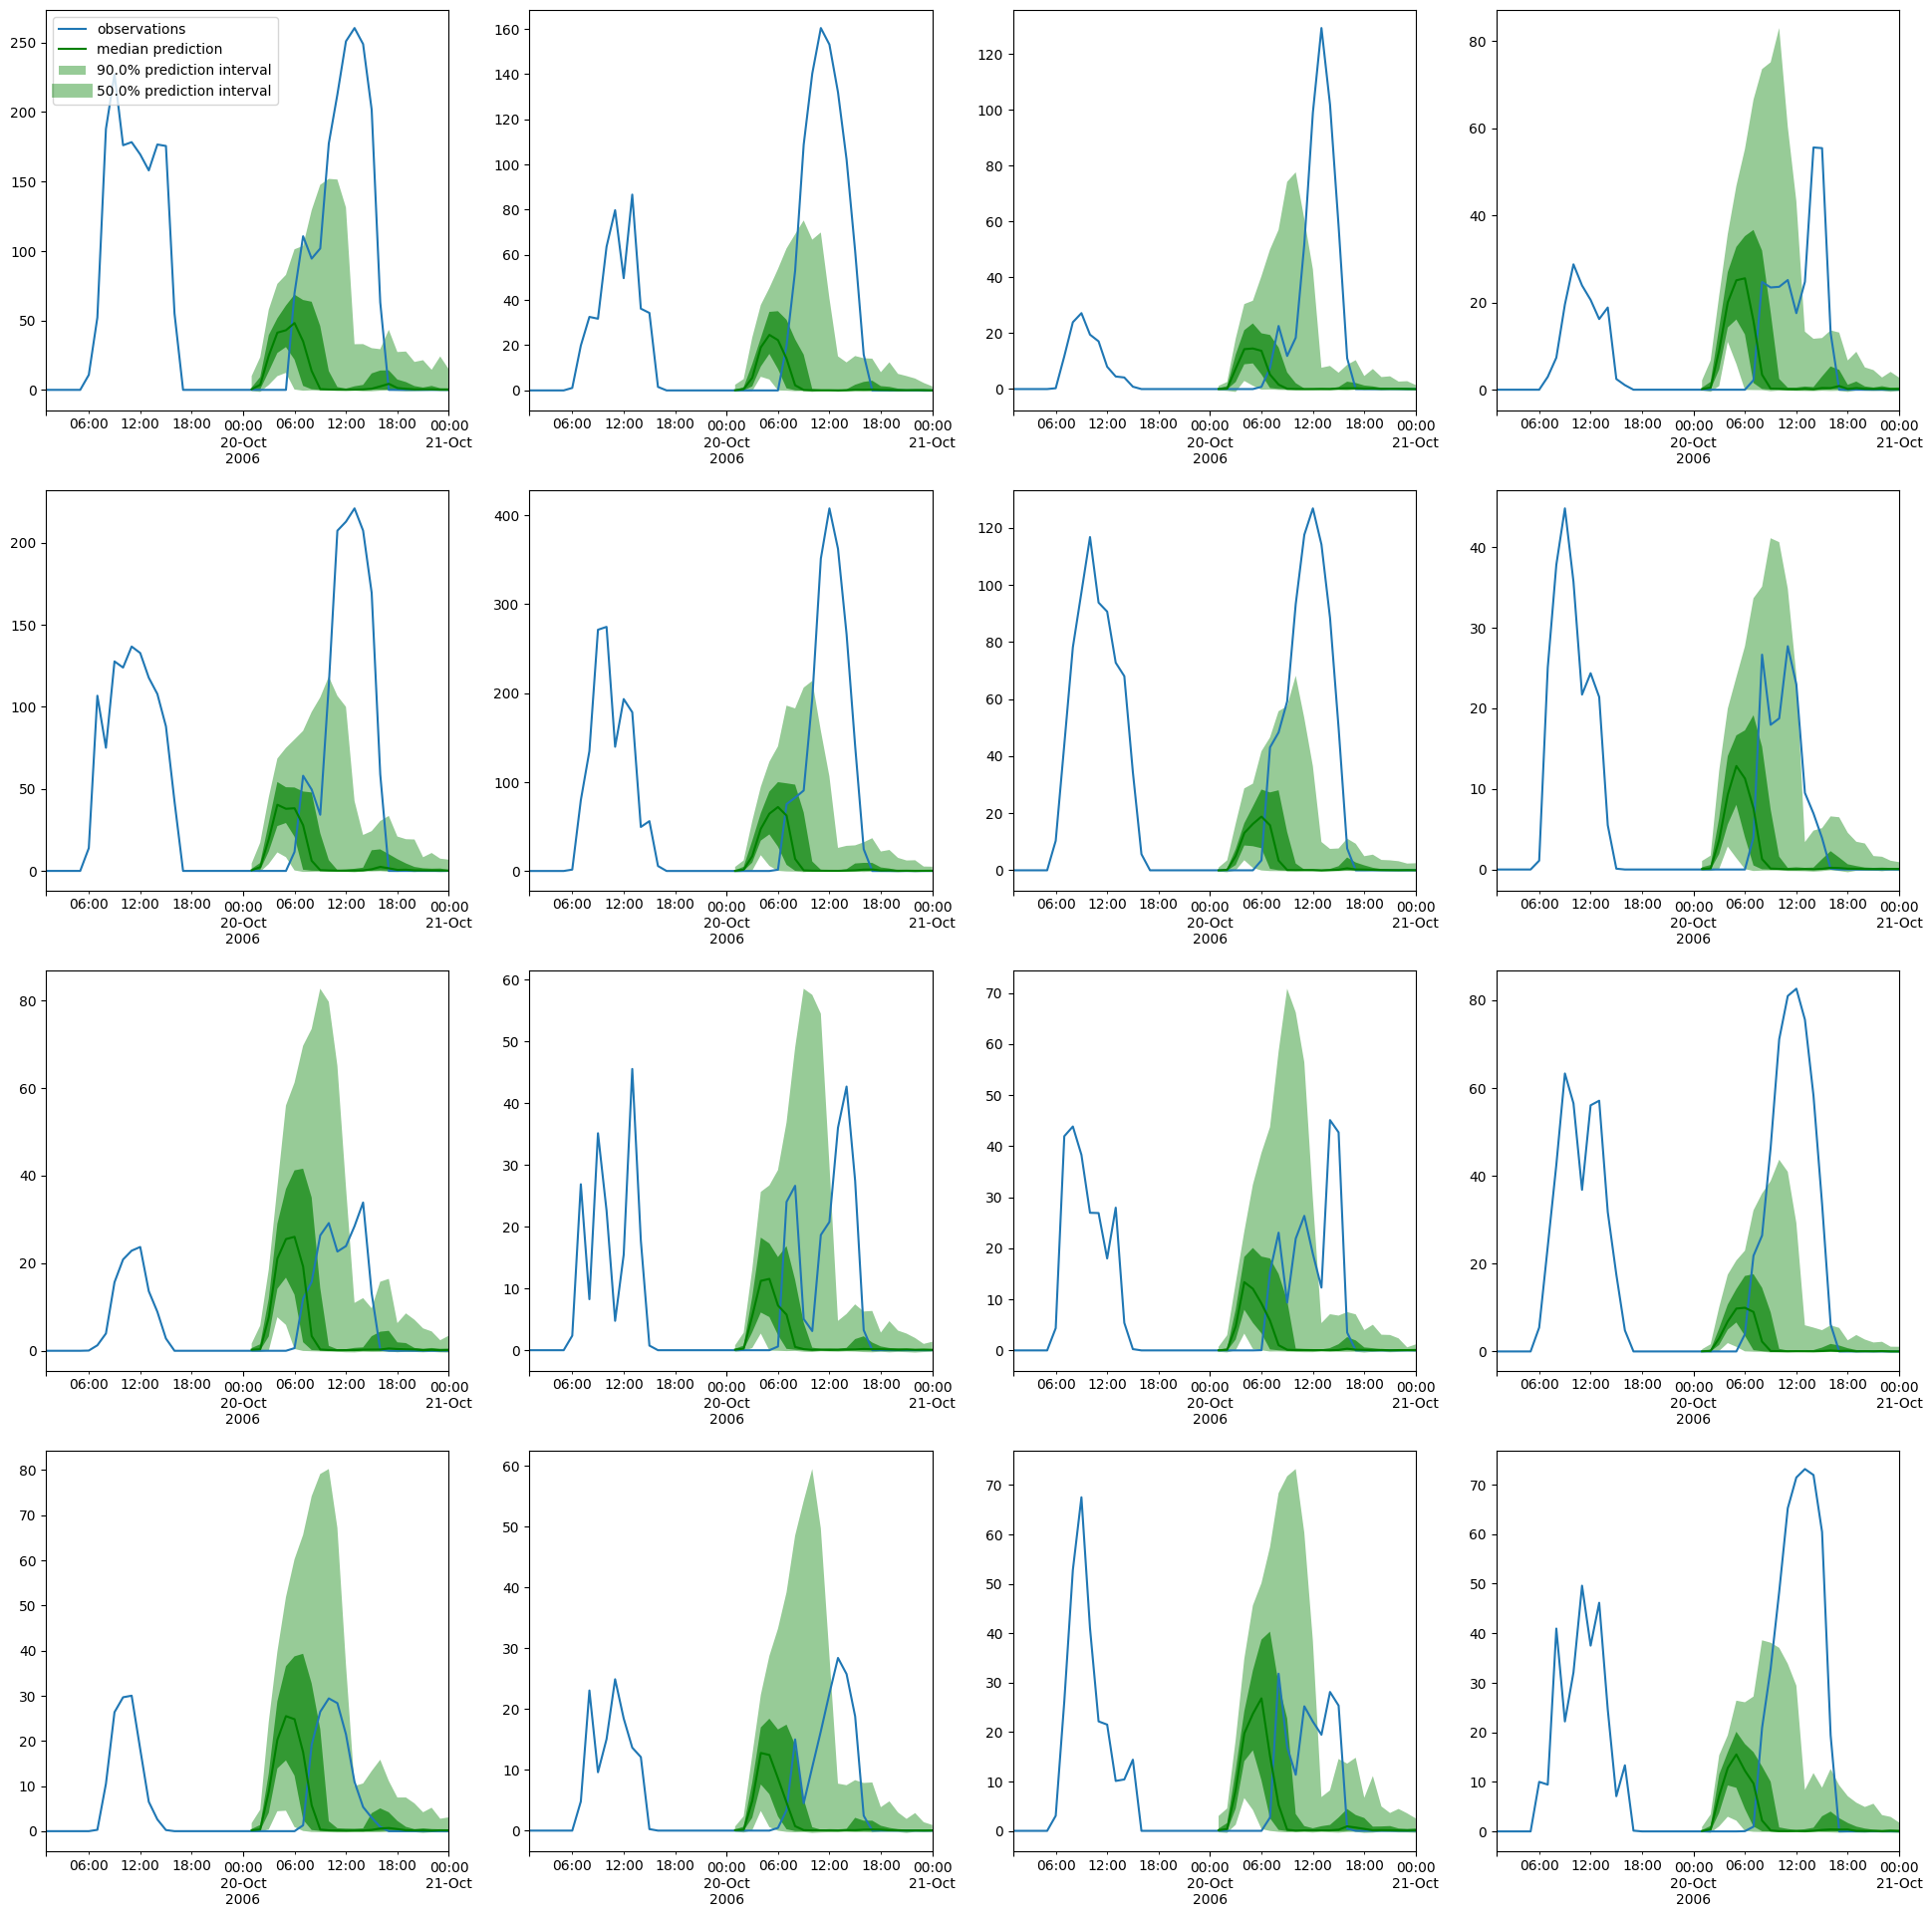

In [17]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)
plt.show()